# Ссылка на презентацию: https://disk.yandex.ru/i/4ij1vMtVfKgAVg

# Цель исследования:

    1. Проанализировать клиентов регионального банка.
    2. Сегментировать пользователей по количеству потребляемых продуктов, обращая особое внимание на отток. 
    3. Построить предположения о том, какими продуктами пользуются клиенты.
    4. Дать рекомендации, как вернуть неактивных клиентов.

# Описание данных:

    
    Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.
Колонки:
    
userid — идентификатор пользователя,

score — баллы кредитного скоринга,

City — город,

Gender — пол,

Age — возраст,

Objects — количество объектов в собственности,

Balance — баланс на счёте,

Products — количество продуктов, которыми пользуется клиент,

CreditCard — есть ли кредитная карта,

Loyalty — активный клиент,

estimated_salary — заработная плата клиента,

Churn — ушёл или нет.

# Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats as st
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from plotly import graph_objects as go
import math as mth
import plotly.express as px
import plotly.graph_objects as go
import json
import warnings # отключили предупреждения      
warnings.filterwarnings('ignore') 
from scipy import stats as st  # для статистики

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv', sep=',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv', sep=',')

# Изучаем общую информацию о полученном датафрейме.

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


###  Применим параметр get.dummies и сделаем копию переменной data

In [4]:
data_corr = pd.get_dummies(data, columns=['city'])
data_corr.head()

,USERID,score,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850.0,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,146556,861.0,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,120722,892.0,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0
3,225363,866.0,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978,730.0,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


### Сразу поменяем названия столбцов equity на оbjects и last_activity на loyalty, как в описании.

In [5]:
data_corr = data_corr.rename(columns={'equity': 'оbjects', 'last_activity': 'loyalty'})

### Переназовем первый столбец.

In [6]:
data_corr = data_corr.rename(columns={'USERID': 'user_id'})
data = data.rename(columns={'USERID': 'user_id'})

In [7]:
#CODE REVIEW
data_review = data.copy()

Выведем основную информацию с помощью метода инфо.

In [8]:
print(data_corr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         10000 non-null  int64  
 1   score           10000 non-null  float64
 2   gender          10000 non-null  object 
 3   age             9974 non-null   float64
 4   оbjects         10000 non-null  int64  
 5   balance         7705 non-null   float64
 6   products        10000 non-null  int64  
 7   credit_card     10000 non-null  int64  
 8   loyalty         10000 non-null  int64  
 9   EST_SALARY      10000 non-null  float64
 10  churn           10000 non-null  int64  
 11  city_Ростов     10000 non-null  uint8  
 12  city_Рыбинск    10000 non-null  uint8  
 13  city_Ярославль  10000 non-null  uint8  
dtypes: float64(4), int64(6), object(1), uint8(3)
memory usage: 888.8+ KB
None


### Посмотрим на пропуски значений. 

In [9]:
#Посмотрим, сколько значений пропущено и в каких столбцах они встречаются.
data_corr.isna().sum()

user_id              0
score                0
gender               0
age                 26
оbjects              0
balance           2295
products             0
credit_card          0
loyalty              0
EST_SALARY           0
churn                0
city_Ростов          0
city_Рыбинск         0
city_Ярославль       0
dtype: int64

В столбце balance пропущено 2295 значений. Предлагаю их никак не заполнять, потому что заполнение медианой или средним может существенно исказить данные.

В столбце age пропущено 26 значений. Их предлагаю пропустить, так как на 10 000 человек пропуск 26 значений это ничтожно малая величина, которой можно пренебречь.

Почему могли возникнуть пропуски:

- человеческий фактор 
- технический сбой

In [10]:
data_corr['user_id'].duplicated().sum()

73

У нас по столбцу 'user_id' 73 дубликата. Это не очень много в виду того, что у нас 10 000 столбцов с данными. Поэтому их можно удалить.

In [11]:
data_corr['user_id'] = data_corr['user_id'].drop_duplicates()

### Приведем все данные к нижнему регистру.

In [12]:
data_corr.columns = data_corr.columns.str.lower()
data_corr.head()

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль
0,183012.0,850.0,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,146556.0,861.0,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,120722.0,892.0,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0
3,225363.0,866.0,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978.0,730.0,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


### Просмотрим, есть ли дубликаты.

In [13]:
print('Количество явных дубликатов:', data_corr.duplicated().sum())

Количество явных дубликатов: 0


### Поменять тип данных в столбцах.

Снова применим метод инфо и посмотрим, что за столбца нуждаются в изменении типа.

In [14]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9927 non-null   float64
 1   score           10000 non-null  float64
 2   gender          10000 non-null  object 
 3   age             9974 non-null   float64
 4   оbjects         10000 non-null  int64  
 5   balance         7705 non-null   float64
 6   products        10000 non-null  int64  
 7   credit_card     10000 non-null  int64  
 8   loyalty         10000 non-null  int64  
 9   est_salary      10000 non-null  float64
 10  churn           10000 non-null  int64  
 11  city_ростов     10000 non-null  uint8  
 12  city_рыбинск    10000 non-null  uint8  
 13  city_ярославль  10000 non-null  uint8  
dtypes: float64(5), int64(5), object(1), uint8(3)
memory usage: 888.8+ KB


In [15]:
data_corr.head()

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль
0,183012.0,850.0,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,146556.0,861.0,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,120722.0,892.0,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0
3,225363.0,866.0,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978.0,730.0,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


In [16]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9927 non-null   float64
 1   score           10000 non-null  float64
 2   gender          10000 non-null  object 
 3   age             9974 non-null   float64
 4   оbjects         10000 non-null  int64  
 5   balance         7705 non-null   float64
 6   products        10000 non-null  int64  
 7   credit_card     10000 non-null  int64  
 8   loyalty         10000 non-null  int64  
 9   est_salary      10000 non-null  float64
 10  churn           10000 non-null  int64  
 11  city_ростов     10000 non-null  uint8  
 12  city_рыбинск    10000 non-null  uint8  
 13  city_ярославль  10000 non-null  uint8  
dtypes: float64(5), int64(5), object(1), uint8(3)
memory usage: 888.8+ KB


### Посмотрим на выбросы в датасете.

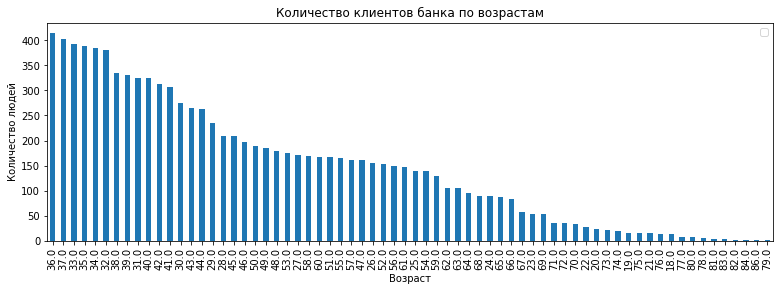

In [17]:
data_corr['age'].value_counts(ascending = False).plot(
        kind='bar', figsize=(13,4))
plt.title("Количество клиентов банка по возрастам")
plt.xlabel("Возраст")
plt.ylabel("Количество людей")
plt.legend('');

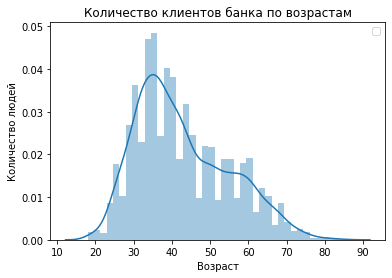

In [18]:
sns_plot = sns.distplot(data_corr['age'])
fig = sns_plot.get_figure()
plt.title("Количество клиентов банка по возрастам")
plt.xlabel("Возраст")
plt.ylabel("Количество людей")
plt.legend('');

In [19]:
data_corr['age'].describe()

count    9974.000000
mean       42.734409
std        12.179971
min        18.000000
25%        33.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

Судя по данным минимальный возраст у нас начинается от 18 лет и до 86. В таком возрасте находятся клиенты банка. Больше всего у банка клиентов 36 лет, их больше 400.
А меньше всего клиентов 82, 84, 79 и 86 лет. Их по одному. Каких-то выбросов на основе этих данных я не вижу, поэтому здесь не будем ничего убирать, а продолжим исследования.

Теперь исследуем столбец с балансом.

In [20]:
# Для нормального отображения дробных чисел (без экспоненциального формата)
pd.options.display.float_format = '{:.5f}'.format

data['balance'].describe([0.9, 0.95, 0.975, 0.99])

count        7705.00000
mean       827794.30651
std       1980614.14686
min             0.00000
50%        524272.20000
90%       1460133.70800
95%       2116704.78400
97.5%     3103499.77400
99%       4827443.49400
max     119113552.01000
Name: balance, dtype: float64

Из вывода describe заметно, что резкое увеличение баланса начинается после 97.5% - значит это можно считать границей выбросов. Посмотрим теперь распределение графически.

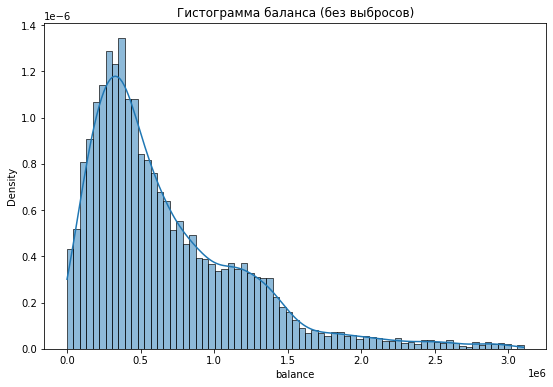

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))

# вычисляем значение 97.5 перцентиля
upper_bound = np.nanpercentile(data['balance'], 97.5)

# создаем фильтр
filter_balance_outliers = (data['balance'] <= upper_bound)

# визуализируем фильтрованные данные
sns.histplot(data=data.loc[filter_balance_outliers], x='balance', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма баланса (без выбросов)")

plt.show()

Получается что 90% клиентов имеют на своих счетах до 1 460 133 рублей. 

Из вывода describe заметно, что резкое увеличение баланса начинается после 97.5% - значит это можно считать границей выбросов. Чтобы посмотреть на основное распределение, надо или фильтровать данные перед визуализацией (мне нравится этот способ) или устанавливать границы по осям - ниже пример 

Теперь можем отфильтровать датафрейм и убрать выбросы по балансу.

In [28]:
data_corr['balance'] = data_corr.query('balance < 3103499')['balance']

In [29]:
data_corr

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль
0,183012.00000,850.00000,Ж,25.00000,1,59214.82000,2,0,1,75719.14000,1,0,1,0
1,146556.00000,861.00000,Ж,37.00000,5,850594.33000,3,1,0,86621.77000,0,0,1,0
2,120722.00000,892.00000,Ж,30.00000,0,NaN,1,1,1,107683.34000,0,0,1,0
3,225363.00000,866.00000,Ж,51.00000,5,1524746.26000,2,0,1,174423.53000,1,0,0,1
4,157978.00000,730.00000,М,34.00000,5,174.00000,1,1,0,67353.16000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553.00000,814.00000,М,27.00000,1,78144.65000,1,0,1,18943.64000,0,0,1,0
9996,139170.00000,894.00000,М,46.00000,0,NaN,1,1,0,196898.29000,0,0,0,1
9997,115639.00000,903.00000,М,24.00000,0,NaN,2,1,1,108905.09000,0,0,0,1
9998,148700.00000,777.00000,Ж,68.00000,3,865457.97000,3,0,1,86874.90000,0,0,0,1


И еще хочу посмотреть отдельно на тех клиентов, кого мы назвали выбросами. Их отделим в отдельную переменную.

In [30]:
vip_clients = data.query('balance > 3103499')
vip_clients

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
44,210313,935.00000,Ярославль,М,41.00000,5,3781118.22000,2,1,0,761349.20000,0
63,140749,948.00000,Ярославль,Ж,34.00000,5,3134788.66000,2,0,0,199705.32000,0
107,134358,985.00000,Рыбинск,Ж,41.00000,4,6749773.07000,2,1,0,698013.27000,0
125,227092,1000.00000,Ярославль,М,32.00000,5,19757180.85000,2,1,1,1024626.50000,0
143,198181,958.00000,Ярославль,М,34.00000,3,5763239.76000,2,1,1,920730.06000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9814,190844,973.00000,Рыбинск,М,49.00000,5,4239884.64000,2,1,0,256105.97000,0
9862,102186,913.00000,Ярославль,М,48.00000,4,4203148.67000,4,1,1,917628.11000,0
9891,161917,963.00000,Ярославль,М,27.00000,4,4028889.42000,2,0,1,376158.61000,1
9908,211089,993.00000,Рыбинск,М,38.00000,6,4542980.70000,1,1,1,491609.13000,1


Посмотрим есть ли выбросы в столбце "score".

In [34]:
data_corr['score'].describe()

count   10000.00000
mean      848.69940
std        65.44852
min       642.00000
25%       802.00000
50%       853.00000
75%       900.00000
max      1000.00000
Name: score, dtype: float64

В этом столбце минимальный скоринговый балл 642. Максимальный 1000. Выбросов нет. Посмотрим графически на распределение.

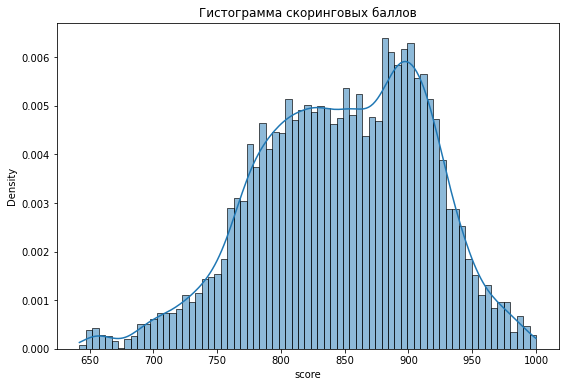

In [35]:
fig, ax = plt.subplots(figsize=(9, 6))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='score', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма скоринговых баллов")

plt.show()

Видно, что чаще всего баллы располагаются от 800 до 900 для большинства пользователей.

In [36]:
data_corr['оbjects'].value_counts()

0    2592
5    1918
4    1850
3    1543
2    1052
1     774
6     161
7      80
8      17
9      13
Name: оbjects, dtype: int64

По объектам есть клиенты с количетсвом объектов от 0 до 9. Посмотрим распределение графически.

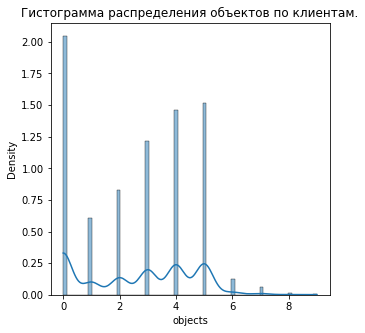

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))

# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='оbjects', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма распределения объектов по клиентам.")

plt.show()

Видно, что больше всего клиентов банка с 0 количеством недвижимости в собственности. На 2 и 3 месте те, кто имеют 5 и 4 объекта в собственности. Ну и последнеи места занимают те, кто имеют 8-9 объектов в собственности.

Ну и последнее, посмотрим в выбросах распределение ежемесячного дохода по столбцу "est_salary".

In [38]:
data_corr['est_salary'].describe([0.9, 0.95, 0.975, 0.99])

count     10000.00000
mean     147866.88554
std      139388.51083
min        2546.30000
50%      119658.10500
90%      242395.78200
95%      316885.34450
97.5%    532915.61725
99%      887903.85460
max     1395064.45000
Name: est_salary, dtype: float64

В среднем оход клиентов банка составляет 147 866. Но есть 10%, где доход свыше 242 000. Максимальный уровень дохода в месяц - 1 395 064 рубля.

Посмотрим на распределение графически.

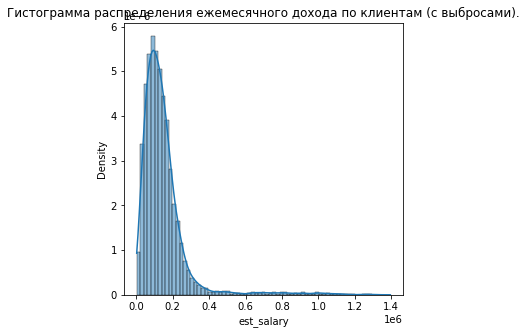

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='est_salary', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма распределения ежемесячного дохода по клиентам (с выбросами).")

plt.show()

На графике тоже видно, что 90% клиентов получают до 200  000 в месяц. В принципе, после 97,5% мы можем откинуть это как выбросы, как аналогично поступили в балансе. Но опять же,я бы отдельно, после исследований дала бы эти данные маркетингу и обратила их внимание, что здесь тоже есть клиенты с которыми можно поработать.

In [40]:
data_corr = data_corr.query('est_salary < 532915')

И теперь посмотрим на распределение без аномально высоких ежемесячных доходов.

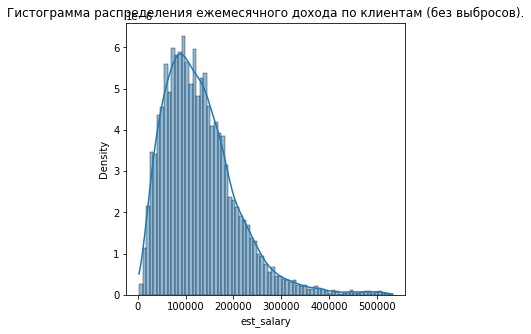

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='est_salary', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма распределения ежемесячного дохода по клиентам (без выбросов).")

plt.show()

In [42]:
data_corr['gender'].value_counts()

Ж    4883
М    4867
Name: gender, dtype: int64

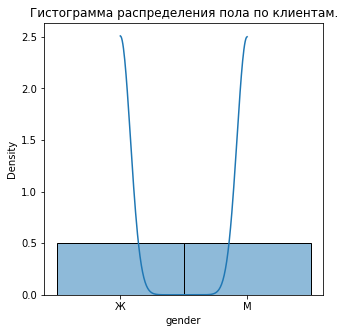

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='gender', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма распределения пола по клиентам.")

plt.show()

Всего в датасете 4883 женщины и 4867 мужчин. На графике выглядит почти поровну.

In [44]:
print('Доля мужчин в столбце gender', round((data_corr.query('gender == "М"')['gender'].count()/data_corr['gender'].count())*100,2))

print('Доля женщин в столбце gender', round((data_corr.query('gender == "Ж"')['gender'].count()/data_corr['gender'].count())*100, 2))


Доля мужчин в столбце gender 49.92
Доля женщин в столбце gender 50.08


Посмотрим, сколько человек пользуются каждым количеством продуктов из датасета.

In [45]:
data_corr['products'].value_counts()

2    5048
1    3191
3    1026
4     465
5      19
0       1
Name: products, dtype: int64

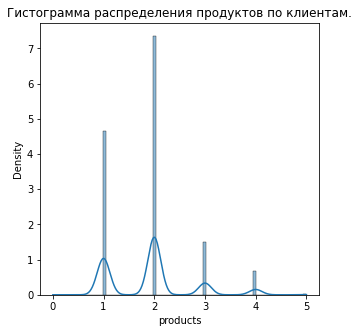

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='products', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма распределения продуктов по клиентам.")

plt.show()

Больше всего людей пользуются двумя продуктами - 5048.

На втором месте использование одного продукта - 3191 человек.

На третьем месте люди, использующие 3 продукта - 1026 человек.

На четвертом месте люди, использующие 4 продукта - 465 человек.

На пятом месте люди, использующие 5 продуктов - 19 человек.

И есть один человек, который использует 0 продуктов.

Посмотрим распределение по лояльности пользователей.

In [47]:
data_corr['loyalty'].value_counts()

1    5092
0    4658
Name: loyalty, dtype: int64

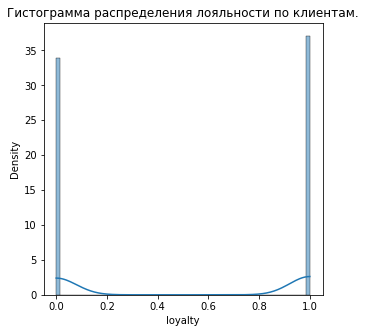

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='loyalty', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Гистограмма распределения лояльности по клиентам.")

plt.show()

Лояльных пользователей 5092, а нелояльных 4658.

### Выводы по данному разделу:


Судя по данным минимальный возраст у нас начинается от 18 лет и до 86. В таком возрасте находятся клиенты банка. Больше всего у банка клиентов 36 лет, их больше 400. А меньше всего клиентов 82, 84, 79 и 86 лет. 

Получается что 90% клиентов имеют на своих счетах до 1 460 133 рублей. 

Чаще всего скоринговые баллы располагаются от 800 до 900 для большинства пользователей.

По объектам есть клиенты с количетсвом объектов от 0 до 9. Больше всего клиентов банка с 0 количеством недвижимости в собственности. На 2 и 3 месте те, кто имеют 5 и 4 объекта в собственности. Ну и последнеи места занимают те, кто имеют 8-9 объектов в собственности.

В среднем оход клиентов банка составляет 147 866. Но есть 10%, где доход свыше 242 000. Максимальный уровень дохода в месяц - 1 395 064 рубля.

Всего в датасете 4883 женщины и 4867 мужчин.

Больше всего людей пользуются двумя продуктами - 5048.

На втором месте использование одного продукта - 3191 человек.

На третьем месте люди, использующие 3 продукта - 1026 человек.

На четвертом месте люди, использующие 4 продукта - 465 человек.

На пятом месте люди, использующие 5 продуктов - 19 человек.

И есть один человек, который использует 0 продуктов.

Лояльных пользователей 5092, а нелояльных 4658.


# Исследовательский анализ данных.

### Посмотреть на корреляцию признаков.
 Для этого сделаем хитмэп. 

Удалим столбец user_id.

In [49]:
data_for_heatmap = data_corr.drop(['user_id'], axis=1)

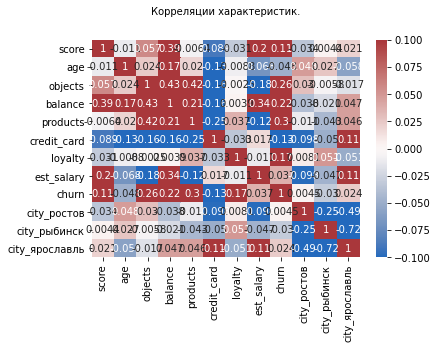

In [50]:
heatmap = sns.heatmap(data_for_heatmap.corr(), vmin=0, vmax=0, annot=True, cmap="vlag",) 

heatmap.set_title('Корреляции характеристик.', fontdict={'fontsize':10}, pad=25);


На количество объектов у нас влияют продукты, которыми пользуются клиенты банка. Мне кажется, что часть клиентов может использовать продукты для приобретения жилья.

Продукты у нас коррелируют с оттоком и объектами.

Кредитные карты коррелируют с мужчинами проживающими в ярославле.

Лояльность коррелирует с оттоком, городом Рыбинском и продуктами.

Ежемесячный доход коррелирует со скоринговым рейтингом, балансом, мужчинами и Ярославлем.

Женщины коррелируют с возрастом.

Мужчины коррелируют с оттоком, ежемесячной зарплатой, кредитными картами и балансом.

### Сравнить портреты типичных клиентов (расчет среднего и медиан по показателям).

#### Начнем с возраста. 

Посмотрим, как он повлияет на отток.

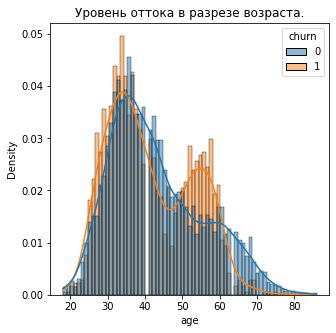

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='age', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе возраста.")

plt.show()

По графику видно, что клиенты уходят из банка в возрасте от 25 до 34. И вторая группа с 50 до 60. В этих группах количество отточных клиентов превышает количество текущих клиентов.

Сначала найдем средний возраст всех пользователей.

In [52]:
data_corr['age'].mean()

42.72678663239075

Средний возраст всех пользователей 42 года.

Затем сгруппируем их по оттоку и найдем среднее.

In [53]:
print('Средний возраст людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['age'].mean(),2))
print('Средний возраст людей, которые ушли из банка', round(data_corr.query('churn == 1')['age'].mean(),2))

Средний возраст людей, которые пользуются услугами банка 43.0
Средний возраст людей, которые ушли из банка 41.49


In [54]:
print('Количество людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['age'].count(),2))
print('Количество людей, которые ушли из банка', round(data_corr.query('churn == 1')['age'].count(),2))

Количество людей, которые пользуются услугами банка 7937
Количество людей, которые ушли из банка 1788


In [55]:
print('Средний уровень оттока', round(data_corr['churn'].mean(),2))
print('Средний уровень оттока в диапазоне с 25 до 34:', round(data_corr.query('age > 25' and 'age <34')['churn'].mean(),2))
print('Средний уровень оттока в диапазоне с 25 до 34:', round(data_corr.query('age > 50' and 'age <60')['churn'].mean(),2))

Средний уровень оттока 0.18
Средний уровень оттока в диапазоне с 25 до 34: 0.21
Средний уровень оттока в диапазоне с 25 до 34: 0.2


In [56]:
print('Медиана возраста людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['age'].median(),2))
print('Медиана по возрасту у людей, которые ушли из банка', round(data_corr.query('churn == 1')['age'].median(),2))

Медиана возраста людей, которые пользуются услугами банка 40.0
Медиана по возрасту у людей, которые ушли из банка 39.0


#### Затем посмотрим влияние скорингового рейтинга на отток

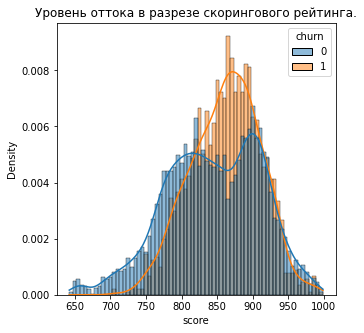

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='score', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе скорингового рейтинга.")

plt.show()

Получается, что количество отточных пользователей выше, когда скоринговые баллы в диапазоне от 800 до 950. То есть люди, которые имеют неплохой рейтинг и могли бы приносить прибыль в банк, уходят от нас.

In [58]:
print('Средний уровень оттока в диапазоне с 800 до 900 скоринговых баллов:', round(data_corr.query('score > 800' and 'score <900')['churn'].mean(),2))

Средний уровень оттока в диапазоне с 800 до 900 скоринговых баллов: 0.19


In [59]:
print('Средний скоринговый рейтинг всех клиентов банка', round(data_corr['score'].mean(),2))
print('Средний скоринговый рейтинг людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['score'].mean(),2))
print('Средний скоринговый рейтинг людей, которые ушли из банка', round(data_corr.query('churn == 1')['score'].mean(),2))

Средний скоринговый рейтинг всех клиентов банка 847.98
Средний скоринговый рейтинг людей, которые пользуются услугами банка 844.76
Средний скоринговый рейтинг людей, которые ушли из банка 862.29


844 балла неплохой скоринговый рейтинг. Но уровень оттока среди клиентов в этом диапазоне очень высокий.

In [60]:
print('Медиана скоринговый рейтинг людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['score'].median(),2))
print('Медиана скоринговый рейтинг у людей, которые ушли из банка', round(data_corr.query('churn == 1')['score'].median(),2))

Медиана скоринговый рейтинг людей, которые пользуются услугами банка 847.0
Медиана скоринговый рейтинг у людей, которые ушли из банка 866.0


#### Посмотрим отток по мужчинам и женщинам.

In [61]:
data.groupby('churn')['gender'].count()

churn
0    8180
1    1820
Name: gender, dtype: int64

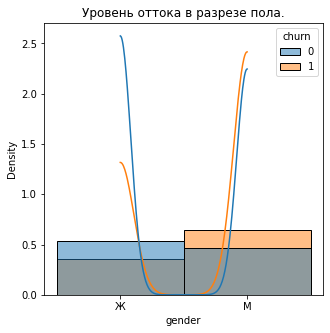

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='gender', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе пола.")

plt.show()

Вот здесь у женщин отток ниже, а у мужчин наоборот выше, судя по графику. Соответственно мужчины находятся в зоне риска покинуть банк.

#### Посмотрим распределение по объектам в разрезе оттока.

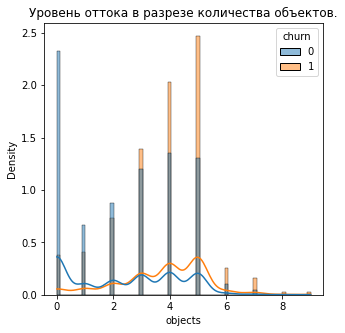

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))

# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='оbjects', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе количества объектов.")

plt.show()

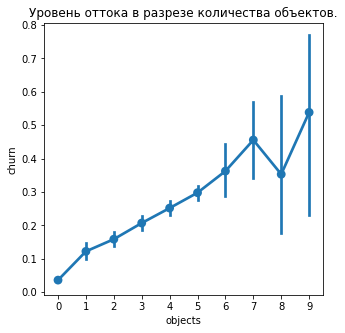

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.pointplot(data=data_corr, x='оbjects', y='churn', ax=ax)
ax.set_title("Уровень оттока в разрезе количества объектов.")

plt.show()

Здесь видно, что отток выше у тех клиентов, которые имеют по 3-7 объектов.Причем самый сильный отток у тех, кто владеет 5 или 4 объектами.

In [65]:
print('Средний уровень оттока с 0 количеством объектов:', round(data_corr.query('оbjects == 0')['churn'].mean(),2))
print('Средний уровень оттока с 1 объектом:', round(data_corr.query('оbjects == 1')['churn'].mean(),2))
print('Средний уровень оттока с 2 объектами:', round(data_corr.query('оbjects == 2')['churn'].mean(),2))
print('Средний уровень оттока с 3 объектами:', round(data_corr.query('оbjects == 3')['churn'].mean(),2))
print('Средний уровень оттока с 4 объектами:', round(data_corr.query('оbjects == 4')['churn'].mean(),2))
print('Средний уровень оттока с 5 объектами:', round(data_corr.query('оbjects == 5')['churn'].mean(),2))
print('Средний уровень оттока с 6 объектами:', round(data_corr.query('оbjects == 6')['churn'].mean(),2))
print('Средний уровень оттока с 7 объектами:', round(data_corr.query('оbjects == 7')['churn'].mean(),2))
print('Средний уровень оттока с 8 объектами:', round(data_corr.query('оbjects == 8')['churn'].mean(),2))
print('Средний уровень оттока с 9 объектами:', round(data_corr.query('оbjects == 9')['churn'].mean(),2))

Средний уровень оттока с 0 количеством объектов: 0.04
Средний уровень оттока с 1 объектом: 0.12
Средний уровень оттока с 2 объектами: 0.16
Средний уровень оттока с 3 объектами: 0.21
Средний уровень оттока с 4 объектами: 0.25
Средний уровень оттока с 5 объектами: 0.3
Средний уровень оттока с 6 объектами: 0.36
Средний уровень оттока с 7 объектами: 0.46
Средний уровень оттока с 8 объектами: 0.35
Средний уровень оттока с 9 объектами: 0.54


In [67]:
print('Средниее количество объектов всех клиентов банка', round(data_corr['оbjects'].mean(),2))
print('Средниее количество объектов у людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['оbjects'].mean(),2))
print('Средниее количество объектов у людей, которые ушли из банка', round(data_corr.query('churn == 1')['оbjects'].mean(),2))

Средниее количество объектов всех клиентов банка 2.66
Средниее количество объектов у людей, которые пользуются услугами банка 2.41
Средниее количество объектов у людей, которые ушли из банка 3.76


#### А теперь проверим связь баланса и оттока.

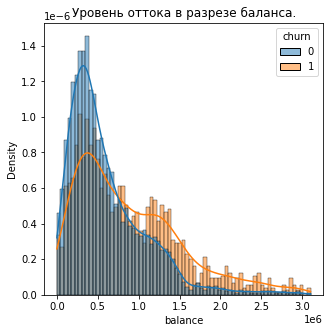

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='balance', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе баланса.")

plt.show()

Судя по графику, видно, что люди с доходом от 700 000 рублей чаще уходят из клиентов банка, чем остаются.
А люди с балансом до 700 000 чаще остаются клиентами банка.

In [69]:
print('Средний баланс всех клиентов банка', round(data_corr['balance'].mean(),2))
print('Средний баланс у людей, которые пользуются услугами банка', round(data_corr.query('churn == 0')['balance'].mean(),2))
print('Средний баланс у людей, которые ушли из банка', round(data_corr.query('churn == 1')['balance'].mean(),2))

Средний баланс всех клиентов банка 668820.75
Средний баланс у людей, которые пользуются услугами банка 604883.49
Средний баланс у людей, которые ушли из банка 884208.02


In [70]:
print('Средний уровень оттока с балансом у людей ниже 700 000:', round(data_corr.query('balance < 700000')['churn'].mean(),2))
print('Средний уровень оттока с балансом у людей выше 700 000:', round(data_corr.query('balance > 700000')['churn'].mean(),2))

Средний уровень оттока с балансом у людей ниже 700 000: 0.17
Средний уровень оттока с балансом у людей выше 700 000: 0.33


#### Теперь исследуем отток в разрезе количества продуктов.

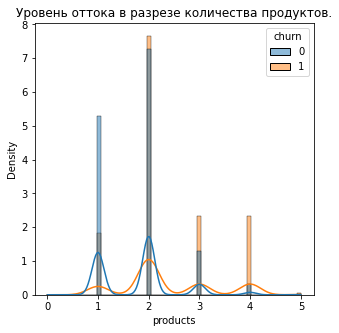

In [71]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='products', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе количества продуктов.")

plt.show()

Видно, что большой уровень оттока у тех, кто использует по 2-4 продукта. А среди использующих 1 продукт больше тех, кто является текущим клиентом банка.

In [72]:
print('Средний уровень оттока при использовании 1 продукта:', round(data_corr.query('products ==1')['churn'].mean(),2))
print('Средний уровень оттока при использовании 2 продуктов:', round(data_corr.query('products ==2')['churn'].mean(),2))
print('Средний уровень оттока при использовании 3 продуктов:', round(data_corr.query('products ==3')['churn'].mean(),2))
print('Средний уровень оттока при использовании 4 продуктов:', round(data_corr.query('products ==4')['churn'].mean(),2))
print('Средний уровень оттока при использовании 5 продуктов:', round(data_corr.query('products ==5')['churn'].mean(),2))

Средний уровень оттока при использовании 1 продукта: 0.07
Средний уровень оттока при использовании 2 продуктов: 0.19
Средний уровень оттока при использовании 3 продуктов: 0.29
Средний уровень оттока при использовании 4 продуктов: 0.63
Средний уровень оттока при использовании 5 продуктов: 0.42


Теперь посмотрим, как средний возраст располагается по продуктам.

In [73]:
#расположение по продуктам среди тех, кто продолжает оставаться клиентом банка
data_corr.query('churn == 0').groupby('products')['age'].mean()

products
1   42.15891
2   43.23007
3   46.41120
4   38.08140
5   36.00000
Name: age, dtype: float64

Средний возраст у неотточных пользователей, которые пользуются 1 продуктом 42 год.

Среди тех, кто пользуется 2 продуктами - 43 лет.

Среди тех, кто пользуется 3 продуктами - 46 года.

Среди тех, кто пользуется 4 продуктами - 38 лет.

Среди тех, кто пользуется 5 продуктами - 36 лет.

In [74]:
#расположение по продуктам среди тех, кто ушел из банка
data_corr.query('churn == 1').groupby('products')['age'].mean()

products
0   79.00000
1   41.51092
2   40.89108
3   44.16041
4   40.79181
5   37.12500
Name: age, dtype: float64

Средний возраст у неотточных пользователей, которые пользуются 1 продуктом 41.5 год.

Среди тех, кто пользуется 2 продуктами - 40.8 лет.

Среди тех, кто пользуется 3 продуктами - 44 года.

Среди тех, кто пользуется 4 продуктами - 40.7 лет.

Среди тех, кто пользуется 5 продуктами - 37 лет.

Посмотрим насколько средние характеристики пользователей 1 продукта отличаются от пользователей 2 продукта и т.д.

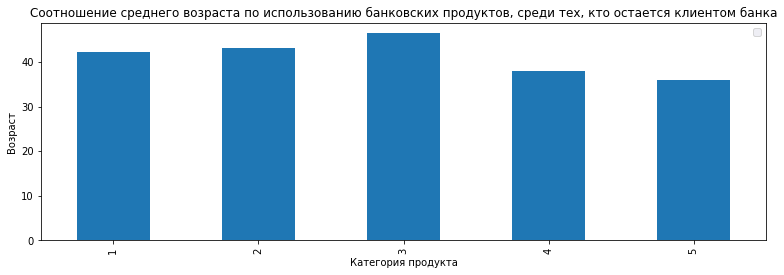

In [75]:
data_corr.query('churn == 0').groupby('products')['age'].mean().plot(
        kind='bar', figsize=(13,4))
plt.title('Соотношение среднего возраста по использованию банковских продуктов, среди тех, кто остается клиентом банка')
sns.set_style('darkgrid')
plt.xlabel("Категория продукта")
plt.ylabel("Возраст")
plt.legend('');

Получается, что самый большой средний возраст у тех, кто не пользуются никакими продуктами. Там средняя цифра 79 лет.
Так как это не отточные люди, то предположу, что они могут просто хранить на своем счете пенсию или какие-то еще сбережения.
Возможно (пока вывод немного на будущее) этому сегменту можно будет предложить услуги по повышенному кешбеку или например по повышенному проценту по сбережениям от Х-суммы денег на счете. Но это только предположения.

Те кто используют продукт № 1, в среднем им около 41.5 лет.

Средний возраст пользователей второго продукта - 40.8 лет.

Средний возраст пользователей третьего продукта - 44.1 лет.

Средний возраст пользователей четвертого продукта - 40.7 лет.

Средний возраст пользователей пятого продукта - 37 лет.

Те, кто перестали быть клиентами банка имеют следующий средний возраст:
 
Клиенты по 1 продукту - 42 года.

Клиенты по 2 продукту - 41 год.

Клиенты по 3 продукту - 46 лет.

Клиенты по 4 продукту - 38 лет.

Клиенты по 5 продукту - 36 лет.

Посмотрим в сумме, сколько клиентов используют какое количество продуктов.

In [76]:
data['products'].value_counts()

2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: products, dtype: int64

Больше всего клиентов используют 2 продукт - 5126 человек.

На втором месте те, кто используют 1 продукт - 3341 человек.

На третьем месте те, кто используют 3 продукта - 1039 человек.

Ну и последние места занимают пользователи с 4 продуктами - 474 человека и 5 продуктами - 19 человек.

In [77]:
data.groupby('churn')['products'].value_counts()

churn  products
0      2           4147
       1           3106
       3            742
       4            174
       5             11
1      2            979
       4            300
       3            297
       1            235
       5              8
       0              1
Name: products, dtype: int64

Больше всего отточных клиентов среди пользователей двумя продуктами - 979.

На втором месте пользователи четырех продуктов - 300. 

А на третьем пользователи трех продуктов - 297.

Посмотрим отдельно на клиента с нулем продуктов. Так как это отточный клиент, которому 79 лет с ежемесячным доходом 25 063 рубля, то возможно он случайно попал в датасет.
В любом случае 1 клиент из 10 000 это ничтожно малое число и можно не обращать на это внимание.

In [78]:
df = data_corr.query('products ==0')
df

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль
8957,147837.00000,962.00000,Ж,79.00000,3,NaN,0,0,0,25063.96000,1,0,1,0


#### Теперь посмотрим на распределение по использованию кредитных карт в разрезе оттока.

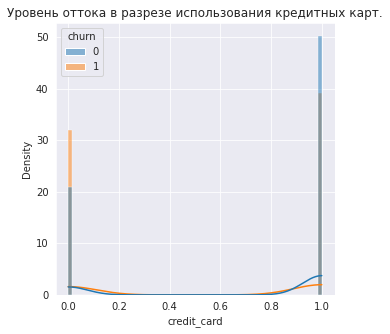

In [81]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='credit_card', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе использования кредитных карт.")

plt.show()

Среди тех, кто не использует кредитные карты большое количество отточных пользователей.

#### Посмотрим, как распределяется отток в разрезе лояльных/нелояльных пользователей.

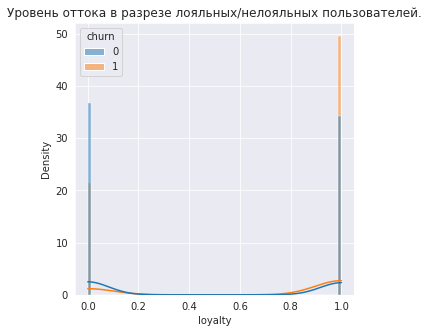

In [83]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='loyalty', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе лояльных/нелояльных пользователей.")

plt.show()

Уровень лояльных пользователей выше у отточных клиентов. А нелояльных наоборот больше среди текущих клиентов.

#### Посмотрим распределение по уровню ежемесячного дохода.

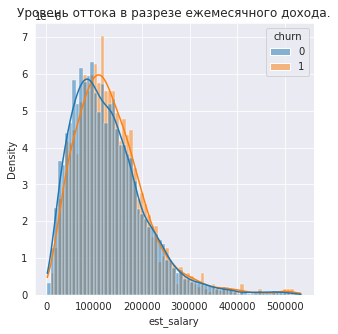

In [84]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='est_salary', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе ежемесячного дохода.")

plt.show()

Начиная со 100 000 ежемесячного дохода и до 500 000 у нас есть риск оттока пользователей.

In [85]:
print('Средний уровень оттока с ежемесячным доходом от 100 000 до 500 000:', round(data_corr.query('est_salary > 100000' and 'est_salary <500000')['churn'].mean(),2))

Средний уровень оттока с ежемесячным доходом от 100 000 до 500 000: 0.18


#### Посмотрим на уровень оттока в разрезе города.

In [86]:
data_corr

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль
0,183012.00000,850.00000,Ж,25.00000,1,59214.82000,2,0,1,75719.14000,1,0,1,0
1,146556.00000,861.00000,Ж,37.00000,5,850594.33000,3,1,0,86621.77000,0,0,1,0
2,120722.00000,892.00000,Ж,30.00000,0,NaN,1,1,1,107683.34000,0,0,1,0
3,225363.00000,866.00000,Ж,51.00000,5,1524746.26000,2,0,1,174423.53000,1,0,0,1
4,157978.00000,730.00000,М,34.00000,5,174.00000,1,1,0,67353.16000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553.00000,814.00000,М,27.00000,1,78144.65000,1,0,1,18943.64000,0,0,1,0
9996,139170.00000,894.00000,М,46.00000,0,NaN,1,1,0,196898.29000,0,0,0,1
9997,115639.00000,903.00000,М,24.00000,0,NaN,2,1,1,108905.09000,0,0,0,1
9998,148700.00000,777.00000,Ж,68.00000,3,865457.97000,3,0,1,86874.90000,0,0,0,1


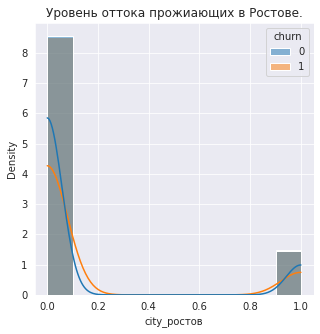

In [87]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='city_ростов', hue='churn', bins=10,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока прожиающих в Ростове.")

plt.show()

По графику видно, что есть риск оттока пользователей, проживающих в Ростове.

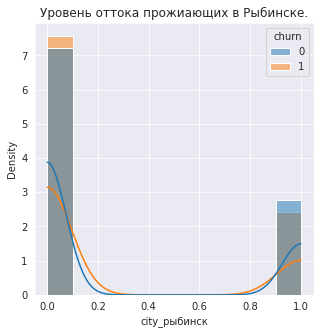

In [88]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='city_рыбинск', hue='churn', bins=10,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока прожиающих в Рыбинске.")

plt.show()

С Рыбинском ситуация обстоит лучше, чем с Ростовом. Там меньшая доля оттока и за этот город можно не волноваться.

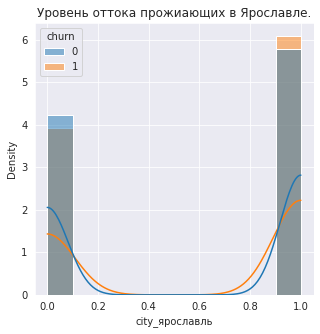

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=data_corr, x='city_ярославль', hue='churn', bins=10,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока прожиающих в Ярославле.")

plt.show()

Рассчитаем средний уровень оттока по городам.

In [90]:
data.groupby('city')['churn'].mean()

city
Ростов      0.18772
Рыбинск     0.16215
Ярославль   0.18971
Name: churn, dtype: float64

В Ярославле тоже высокий уровень оттока, среди проживающих в городе.

Итого получается, что в Рыбинске самые лояльные клиенты, а вот в Ростове и Ярославле высокие уровни оттока. По среднему уровню оттока подтвержаются эти данные с графиками.

Больше всего клиентов банка в Ярославле - 5888. На втором месте Рыбинск - 2695. А на третьем месте Ростов - 1417.

Посмотрим, как обстоят дела с отточными и неотточными пользователями.

In [91]:
data.groupby('churn')['city'].value_counts()

churn  city     
0      Ярославль    4771
       Рыбинск      2258
       Ростов       1151
1      Ярославль    1117
       Рыбинск       437
       Ростов        266
Name: city, dtype: int64

Видно, что самый большой отток пользователей был в Ярославле - 1117 человек. 
На втором месте Рыбинск - 437 человек.
А на тратьем Ростов - 266 человек. 
В принципе точно также распределяются и пользователи по количеству человек в банке.

#### Выводы по признакам в разрезе оттока.

По графику видно, что клиенты уходят из банка в возрасте от 25 до 34. И вторая группа с 50 до 60. В этих группах количество отточных клиентов превышает количество текущих клиентов.

Получается в 41-42 года человек еще пользуется услугами банка, а затем уходит.

Получается, что количество отточных пользователей выше, когда скоринговые баллы в диапазоне от 800 до 950. То есть люди, которые имеют неплохой рейтинг и могли бы приносить прибыль в банк, уходят от нас.

Средний скоринговый рейтинг всех клиентов банка 847.98
Средний скоринговый рейтинг людей, которые пользуются услугами банка 844.76
Средний скоринговый рейтинг людей, которые ушли из банка 862.29

Отток выше у тех клиентов, которые имеют по 3-7 объектов.Причем самый сильный отток у тех, кто владеет 5 или 4 объектами.

Средниее количество объектов всех клиентов банка 2.66
Средниее количество объектов у людей, которые пользуются услугами банка 3.76
Средниее количество объектов у людей, которые ушли из банка 2.41.

Судя по графику, видно, что люди с доходом от 700 000 рублей чаще уходят из клиентов банка, чем остаются. А люди с балансом до 700 000 чаще остаются клиентами банка.

Средний баланс всех клиентов банка 668820.75
Средний баланс у людей, которые пользуются услугами банка 884208.02
Средний баланс у людей, которые ушли из банка 604883.49

Видно, что большой уровень оттока у тех, кто использует по 2-4 продукта. А среди использующих 1 продукт больше тех, кто является текущим клиентом банка.



Средний возраст у неотточных пользователей, которые пользуются 1 продуктом 41.5 год.

Среди тех, кто пользуется 2 продуктами - 40.8 лет.

Среди тех, кто пользуется 3 продуктами - 44 года.

Среди тех, кто пользуется 4 продуктами - 40.7 лет.

Среди тех, кто пользуется 5 продуктами - 37 лет.



Больше всего клиентов используют 2 продукт - 5126 человек.

На втором месте те, кто используют 1 продукт - 3341 человек.

На третьем месте те, кто используют 3 продукта - 1039 человек.

Ну и последние места занимают пользователи с 4 продуктами - 474 человека и 5 продуктами - 19 человек.

Больше всего отточных клиентов среди пользователей двумя продуктами - 979.

На втором месте пользователи четырех продуктов - 300.

А на третьем пользователи трех продуктов - 297.

Среди тех, кто не использует кредитные карты большое количество отточных пользователей.

Уровень лояльных пользователей выше у отточных клиентов. А нелояльных наоборот больше среди текущих клиентов.

Начиная со 100 000 ежемесячного дохода и до 500 000 у нас есть риск оттока пользователей.

Больше всего клиентов банка в Ярославле - 5888. На втором месте Рыбинск - 2695. А на третьем месте Ростов - 1417.
Видно, что самый большой отток пользователей был в Ярославле - 1117 человек. На втором месте Рыбинск - 437 человек. А на тратьем Ростов - 266 человек. В принципе точно также распределяются и пользователи по количеству человек в банке.


### Определим сегменты.

Для начала определим, что возьмем за признаки, которые будут влиять на сегментацию.

1. Количество продуктов.
2. Баланс.

Предварительно сделаем 3 крупных сегмента.

1 семент. Люди, испольщующие 1 продукт. Они лояльные и не отточные.

2 сегмент. Люди использующие 2-3 продукта. Здесь уже есть уровень оттока.

3 сегмент. Люди использующие 4-5 продуктов. 

Посмотрим, как распределить баланс. Создадим 2 переменные с разным уровнем баланса.

In [93]:
filter_balance_less = (data_corr['balance'] <= 500000) & (data_corr['balance'] >= 250000)
filter_balance_more = (data_corr['balance'] >= 1150000)

In [94]:
print("Средний уровень оттока по всему датафрейму:", round(data_corr['churn'].mean(),2))
print("Средний уровень оттока в диапазоне от 250 000 до 500 000:", round(data_corr.loc[filter_balance_less, 'churn'].mean(),2))
print("Средний уровень оттока в диапазоне свыше 1 150 000:", round(data_corr.loc[filter_balance_more, 'churn'].mean(),2))

Средний уровень оттока по всему датафрейму: 0.18
Средний уровень оттока в диапазоне от 250 000 до 500 000: 0.17
Средний уровень оттока в диапазоне свыше 1 150 000: 0.41


In [95]:
data_for_rewev = (data_corr['balance'] >= 1150000) & (data_corr['products'] == 1)
data_corr.loc[data_for_rewev, 'churn'].mean()

0.15702479338842976

В диапзоне свыше 1 150 000 уровень оттока выше среднего по всему датафрейму. Внесем этот фильтр в отдельный столбец.

In [96]:
data_corr['is_hight_balance'] = filter_balance_more

Построим теперь графики для выделенных групп по балансу.

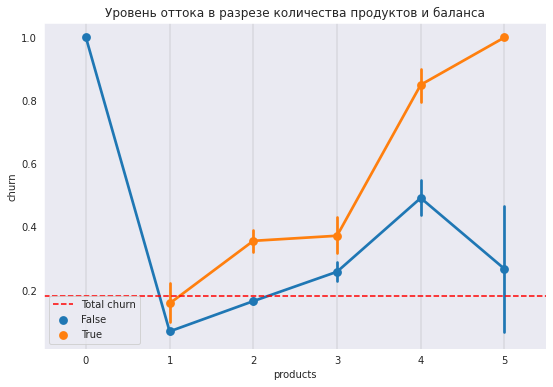

In [97]:
fig, ax = plt.subplots(figsize=(9, 6))

# визуализируем фильтрованные данные
sns.pointplot(data=data_corr, x='products', y='churn', hue='is_hight_balance', ax=ax)
ax.set_title("Уровень оттока в разрезе количества продуктов и баланса")
ax.grid(c='grey',lw=0.25)
ax.axhline(data_review['churn'].mean(), label='Total churn', ls='--', c='red')
ax.legend()

plt.show()

Получается, что люди с балансом выше 1 150 000 рублей имеют  1 продукт, но их уровень ниже уровня среднего оттока. При использовании двух продуктов и далее их уровень выше среднего уровня оттока.

Сначала проверим, какой средний отток у людей, чей доход выше 1 150 000 и с 1 продуктом.

In [98]:
data_for_rewev = (data_corr['balance'] >= 1150000) & (data_corr['products'] == 1)
data_corr.loc[data_for_rewev, 'churn'].mean()
print("Средний отток у людей, которые пльзуются 1 продуктом и имеют средний доход выше 1 150 000:", round(data_corr.loc[data_for_rewev, 'churn'].mean(),2))
print("Средний уровень оттока в диапазоне свыше 1 150 000:", round(data_corr.loc[filter_balance_more, 'churn'].mean(),2))

Средний отток у людей, которые пльзуются 1 продуктом и имеют средний доход выше 1 150 000: 0.16
Средний уровень оттока в диапазоне свыше 1 150 000: 0.41


Получается, что при таком балансе, единственные, кто не в группе риска - это люди, использующие 1 продукт. Дальше идет % оттока выше, чем средний продукт.

Сделаем сводную таблицу, где объединим количество продуктов, баланс выше 1 150 000 рублей и возьмем клиентов по Ростову, там больше всего клиентов и соответственно отток тоже выше.

In [99]:
data_for_segments = data_corr.pivot_table(index='products', columns='is_hight_balance', values='city_ростов', aggfunc='count')
data_for_segments

is_hight_balance,False,True
products,,
0,1.00000,NaN
1,3070.00000,121.00000
2,4339.00000,709.00000
3,773.00000,253.00000
4,285.00000,180.00000
5,15.00000,4.00000


Получается в Ростове 121 клиентов с доходом выше 1 150 000 рублей пользуются 1 продуктом.

709 человек пользуются 2 продуктами.

253 человек пользуются 3 продуктами.

180 человека пользуются четырьмя продуктами.

И 4 человека пользуются пятью продуктами.

Итого у нас получается 4 сегмента:
    
1. Пользователи с доходом свыше 1 150 000 рублей, использующие 1 продукт и проживающие в Ростове. Так как уровень оттока у них ниже среднего уровня оттока (при уровне оттока в этой группе 16%, а среднем оттоке 18%), то решим, что это идеальные клиенты. Поэтому с ними можно только продолжать работать дальше и не волноваться. Пока отток им не грозит. Так как их всего 121, то это слишком мало для данного проекта.

   Соответственно рекомендаций для этой группы можно не делать. Хотя, так как у нас нужно найти группы по 200-300 человек, то можно не брать этот сегмент, а сосредоточиться на 709 людях, использующих 2 продукта. Как раз, если дальше провести сегментацию по еще одному виду, то можно плотнее поработать с этими людьми и разделить второй сегмент на 2 более мелких сегмента. Так мы получим 4 необходимых сегмента для отдела маркетинга


2. Пользователи с доходом свыше 1 150 000 рублей, использующие 2 продукта и проживающие в Ростове. Их уровень оттока выше среднего уровня оттока. Но так как их 709 человек, то нужно более детально сегментировать эту группу и найти признак, по которому их сегментировать.


3. Пользователи с доходом свыше 1 150 000 рублей, использующие 3 продукта и проживающие в Ростове. Их уровень оттока уже выше, чем средний отток.  А еще их 253 человека, поэтому эта группа идеально подойдет для сегментирования.


4. Пользователи с доходом свыше 1 150 000 рублей, использующие 4-5 продукта и проживающие в Ростове. Их уровень оттока выше среднего. И так как в сумме их 184, то это подходит под условия сегментации, соответственно данный сегмент можно дальше не делить.


Займемся вторым сегментом. Отделим с помощью атрибута query необходимые нам условия в отдельную переменную.

In [100]:
segment_2 = data_corr.query('products == 2' and 'city_ростов == True' and 'balance <= 1150000')

Посмотрим, какой еще признак сильно влияет на уровень оттока и позволит сузить сегмент. Посмотрим распределение оттока в segment_2.

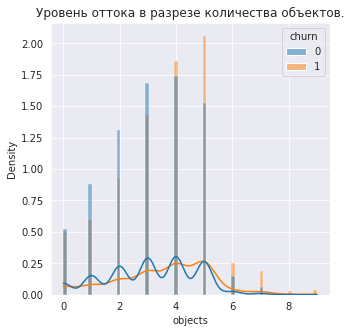

In [101]:
fig, ax = plt.subplots(figsize=(5, 5))


# визуализируем фильтрованные данные
sns.histplot(data=segment_2 , x='оbjects', hue='churn', bins=71,  
             kde=True, stat='density', common_norm=False , ax=ax)
ax.set_title("Уровень оттока в разрезе количества объектов.")

plt.show()

С 4 до 7 объектов отток у пользователей значительно возрос. Посмотрим, сколько человек имеют с 4 по 7 объектов и являются отточными.

In [102]:
segment_2

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль,is_hight_balance
0,183012.00000,850.00000,Ж,25.00000,1,59214.82000,2,0,1,75719.14000,1,0,1,0,False
1,146556.00000,861.00000,Ж,37.00000,5,850594.33000,3,1,0,86621.77000,0,0,1,0,False
4,157978.00000,730.00000,М,34.00000,5,174.00000,1,1,0,67353.16000,1,0,0,1,False
5,202305.00000,856.00000,М,56.00000,4,863687.24000,3,1,0,156619.80000,0,0,1,0,False
6,177259.00000,807.00000,Ж,39.00000,3,405042.44000,3,0,1,103838.32000,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,122366.00000,840.00000,Ж,44.00000,3,326619.71000,1,1,0,157589.59000,0,0,0,1,False
9992,167165.00000,813.00000,М,48.00000,2,179765.62000,2,1,0,133972.11000,1,0,1,0,False
9994,114186.00000,851.00000,М,42.00000,3,370912.79000,2,1,0,102123.93000,1,1,0,0,False
9995,120553.00000,814.00000,М,27.00000,1,78144.65000,1,0,1,18943.64000,0,0,1,0,False


In [103]:
segment_2.groupby('churn')['оbjects'].value_counts()

churn  оbjects
0      4          1110
       3          1072
       5           970
       2           833
       1           560
       0           334
       6            95
       7            39
       8            10
       9             6
1      5           311
       4           281
       3           216
       2           140
       1            90
       0            77
       6            38
       7            29
       9             6
       8             4
Name: оbjects, dtype: int64

Во 2 сегменте 281 отточный пользователь имеет 4 объекта.

5 объектов имеют 311 пользователей.

3 объекта имеют 216 пользователей.

Итого, можно разделить 2 сегмент на два разных сегмента. В одном будут люди, имеющие 3 объекта, а во втором люди имеющие 4 объекта. Их количество подходит под нужное нам и они все отточные. 

In [104]:
data_corr

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль,is_hight_balance
0,183012.00000,850.00000,Ж,25.00000,1,59214.82000,2,0,1,75719.14000,1,0,1,0,False
1,146556.00000,861.00000,Ж,37.00000,5,850594.33000,3,1,0,86621.77000,0,0,1,0,False
2,120722.00000,892.00000,Ж,30.00000,0,NaN,1,1,1,107683.34000,0,0,1,0,False
3,225363.00000,866.00000,Ж,51.00000,5,1524746.26000,2,0,1,174423.53000,1,0,0,1,True
4,157978.00000,730.00000,М,34.00000,5,174.00000,1,1,0,67353.16000,1,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553.00000,814.00000,М,27.00000,1,78144.65000,1,0,1,18943.64000,0,0,1,0,False
9996,139170.00000,894.00000,М,46.00000,0,NaN,1,1,0,196898.29000,0,0,0,1,False
9997,115639.00000,903.00000,М,24.00000,0,NaN,2,1,1,108905.09000,0,0,0,1,False
9998,148700.00000,777.00000,Ж,68.00000,3,865457.97000,3,0,1,86874.90000,0,0,0,1,False


In [105]:
print('Средний уровень оттока в 1 сегменте:', round(data_corr.query('balanse > 1150000' and 'products ==2' and 'оbjects ==3' and 'city_ростов ==1')['churn'].mean(),2))
print('Средний уровень оттока в 2 сегменте:', round(data_corr.query('balanse > 1150000' and 'products ==2' and 'оbjects ==4' and 'city_ростов ==1')['churn'].mean(),2))
print('Средний уровень оттока в 3 сегменте:', round(data_corr.query('balanse > 1150000' and 'products ==3' and 'city_ростов ==1')['churn'].mean(),2))
print('Средний уровень оттока в 4 сегменте:', round(data_corr.query('balanse > 1150000' and 'products ==4' or 'products ==5' and 'city_ростов ==1')['churn'].mean(),2))

Средний уровень оттока в 1 сегменте: 0.19
Средний уровень оттока в 2 сегменте: 0.19
Средний уровень оттока в 3 сегменте: 0.19
Средний уровень оттока в 4 сегменте: 0.63


Получившиеся сегменты
    
    Итого у нас получается 4 сегмента:

1) Пользователи с балансом свыше  1 150 000рублей, использующие 2 продукта, проживающие в Ростове и имеющие 3 объекта. Таких всего 216 пользователей, а их отток выше среднего.

2) Пользователи с балансом свыше  1 150 000рублей, использующие 2 продукта, проживающие в Ростове и имеющие 4 объекта. Таких всего 281 пользователь, а их отток выше среднего.


3) Пользователи с балансом свыше 1 150 000 рублей, использующие 3 продукта и проживающие в Ростове. Их уровень оттока уже выше, чем средний отток.  А еще их 253 человека, поэтому эта группа идеально подойдет для сегментирования.

4) Пользователи с балансом свыше 1 150 000 рублей, использующие 4-5 продукта и проживающие в Ростове. Их уровень оттока выше среднего. И так как в сумме их 184, то это подходит под условия сегментации, соответственно данный сегмент можно дальше не делить.

### Проверка статистических гипотез
1. Проверить гипотезу различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним продуктом банка.

2. Проверить гипотезу различия лояльности между теми пользователи, которые пользуются двумя продуктами банка.

Сформулируем нулевую и алььернативную гипотезы для первого варианта.

Н0: возраст пользователей одного продукта банка и двух продуктов банка не различается.
    
Н1: возраст пользователей, которые используют 1 продукт банка и 2 продукта банка различается.

Запишем количество пользователей по 1 b 2 группам в отдельные переменные.

In [106]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,balance_masked
0,183012,850.00000,Рыбинск,Ж,25.00000,1,59214.82000,2,0,1,75719.14000,1,59214.82000
1,146556,861.00000,Рыбинск,Ж,37.00000,5,850594.33000,3,1,0,86621.77000,0,850594.33000
2,120722,892.00000,Рыбинск,Ж,30.00000,0,NaN,1,1,1,107683.34000,0,NaN
3,225363,866.00000,Ярославль,Ж,51.00000,5,1524746.26000,2,0,1,174423.53000,1,1524746.26000
4,157978,730.00000,Ярославль,М,34.00000,5,174.00000,1,1,0,67353.16000,1,174.00000


In [107]:
users_bygroup_1 = data_corr[(data_corr['products'] == 1)]['age']
users_bygroup_2 = data_corr[(data_corr['products'] == 2)]['age']

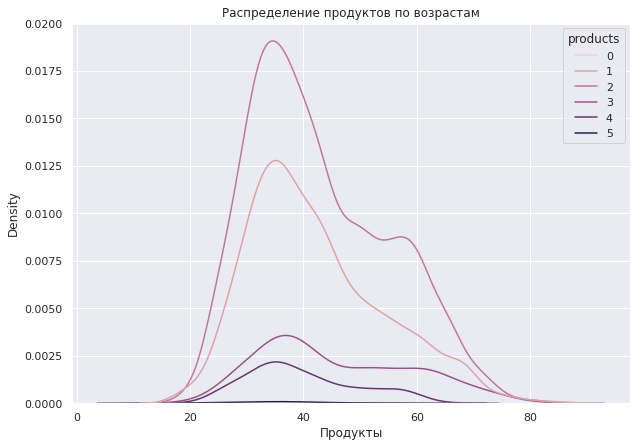

In [108]:
sns.set(rc={'figure.figsize':(10,7)})
sns.kdeplot(x='age', data = data_corr, hue='products', vertical = False)
sns.set_style('darkgrid')
plt.title("Распределение продуктов по возрастам")
plt.xlabel("Продукты");

По графику видно, что распределение у возрастов по 1 и 2 продукту очень похожи до 40 лет. А с 40 до 80 наблюдается расхождение.

Распределение возраста клиентов, пользующися 1 продуктом


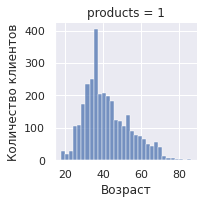

In [109]:
print('Распределение возраста клиентов, пользующися 1 продуктом')

sns.displot(data=data_corr.query('products == 1'), x='age', col='products', height=3).set(xlabel="Возраст", ylabel='Количество клиентов')


Распределение возраста клиентов, пользующися 2 продуктами


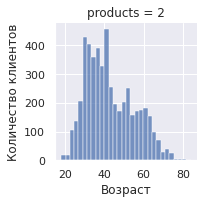

In [110]:
print('Распределение возраста клиентов, пользующися 2 продуктами')

sns.displot(data=data_corr.query('products == 2'), x='age', col='products', height=3).set(xlabel="Возраст", ylabel='Количество клиентов')


Посмотрим на отношение количества людей по возрасту с использование 1 или 2-х продуктов ко всем остальным людям.

In [111]:
users_bygroup_1 = data_corr.query('products == 1')['age']
users_bygroup_2 = data_corr.query('products == 2')['age']

In [112]:
print('Отношение количества людей по возрасту из 1 группы ко всем', (users_bygroup_1.count()/ data_corr['age'].count()*100))
print('Отношение количества людей по возрасту из 2 группы ко всем', (users_bygroup_2.count()/ data_corr['age'].count()*100))

Отношение количества людей по возрасту из 1 группы ко всем 32.637532133676096
Отношение количества людей по возрасту из 2 группы ко всем 51.83547557840617


In [113]:
data_corr['age'].count()

9725

Здесь хочу выбрать t-test для проверки гипотезы. Так как здесь достаточно большие выборки. Группы с использованием одного и 2 продуктов самые большие. Первая занимает 32% от общей массы, а вторая 51.8% от общей массы. А еще выборки не зависят друг от друга.

In [114]:
users_bygroup_1 = data_corr.query('products == 1')['age']
users_bygroup_2 = data_corr.query('products == 2')['age']

In [115]:
results = st.ttest_ind(users_bygroup_1, users_bygroup_2, equal_var=False, nan_policy ='omit')

alpha = 0.01

print(results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима.")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.")

0.014084943223794734
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


 ### Проверить гипотезу различия ежемесячного дохода между клиентами, которые пользуются 1 или 2 продуктами банка. Или связи между этими двумя пунктами нет.

Сформулируем нулевую и альтернативную гипотезы для первого варианта.

Н0: Доход клиентов, которые пользуются 1 или 2 продуктами банка не различается.

Н1: Доход клиентов, которые пользуются 1 или 2 продуктами банка различается.

In [116]:
data_corr

,user_id,score,gender,age,оbjects,balance,products,credit_card,loyalty,est_salary,churn,city_ростов,city_рыбинск,city_ярославль,is_hight_balance
0,183012.00000,850.00000,Ж,25.00000,1,59214.82000,2,0,1,75719.14000,1,0,1,0,False
1,146556.00000,861.00000,Ж,37.00000,5,850594.33000,3,1,0,86621.77000,0,0,1,0,False
2,120722.00000,892.00000,Ж,30.00000,0,NaN,1,1,1,107683.34000,0,0,1,0,False
3,225363.00000,866.00000,Ж,51.00000,5,1524746.26000,2,0,1,174423.53000,1,0,0,1,True
4,157978.00000,730.00000,М,34.00000,5,174.00000,1,1,0,67353.16000,1,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553.00000,814.00000,М,27.00000,1,78144.65000,1,0,1,18943.64000,0,0,1,0,False
9996,139170.00000,894.00000,М,46.00000,0,NaN,1,1,0,196898.29000,0,0,0,1,False
9997,115639.00000,903.00000,М,24.00000,0,NaN,2,1,1,108905.09000,0,0,0,1,False
9998,148700.00000,777.00000,Ж,68.00000,3,865457.97000,3,0,1,86874.90000,0,0,0,1,False


In [117]:
product_1 = data_corr.query('products ==1')['est_salary']
product_2 = data_corr.query('products ==2')['est_salary']

In [118]:
print('Количество клиентов с 1 продуктом:', product_1.count())
print('Количество клиентов с 2 продуктами:', product_2.count())

Количество клиентов с 1 продуктом: 3191
Количество клиентов с 2 продуктами: 5048


Распределение дохода клиентов, пользующися 1 продуктом


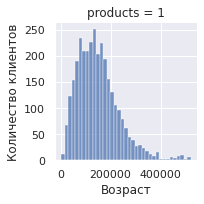

In [119]:
print('Распределение дохода клиентов, пользующися 1 продуктом')

sns.displot(data=data_corr.query('products == 1'), x='est_salary', col='products', height=3).set(xlabel="Возраст", ylabel='Количество клиентов')


Распределение дохода клиентов, пользующися 2 продуктом


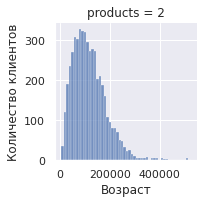

In [120]:
print('Распределение дохода клиентов, пользующися 2 продуктом')

sns.displot(data=data_corr.query('products == 2'), x='est_salary', col='products', height=3).set(xlabel="Возраст", ylabel='Количество клиентов')


По графику можно сказать, что распределение очень похожее, но единственное у пользователей, пользующихся 2 продуктами меньшее количество людей имеет доход от 200 до 400 тысяч.

In [121]:
print('Отношение количества людей по доходу из 1 группы ко всем', (product_1.count()/ data_corr['est_salary'].count()*100))
print('Отношение количества людей по доходу из 2 группы ко всем', (product_2.count()/ data_corr['est_salary'].count()*100))

Отношение количества людей по доходу из 1 группы ко всем 32.728205128205126
Отношение количества людей по доходу из 2 группы ко всем 51.77435897435897


Здесь хочу выбрать t-test для проверки гипотезы. Так как здесь достаточно большие выборки. Группы с использованием одного и 2 продуктов самые большие. А еще выборки не зависят друг от друга.

In [122]:
results = st.ttest_ind(product_1, product_2, equal_var=False, nan_policy ='omit')

alpha = 0.01

print(results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима.")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.")

1.0899855517073636e-65
Отвергаем нулевую гипотезу: разница статистически значима.


# Выводы и рекомендации для заказчика.

## Общий вывод:

Судя по данным минимальный возраст у нас начинается от 18 лет и до 86. В таком возрасте находятся клиенты банка. Больше всего у банка клиентов 36 лет, их больше 400. А меньше всего клиентов 82, 84, 79 и 86 лет. 

Но средний возраст пользователей банковских продуктов начинается с 34 и до 45. Люди остального возраста редко пользуются банковскими продуктами.

В датасете были люди, которые пользовались от 1 до 5 продуктами. И их поведение мы исследовали.

Средний возраст всех пользователей 42 года.
Средний возраст людей, которые ушли из банка 41.49

Получается, что самый большой средний возраст у тех, кто не пользуются никакими продуктами. Там средняя цифра 79 лет.

Самый большой по потреблению сегмент занимают пользователи двух продуктов - 51.3%. На втором месте пользователи одного продукта. Их 33,4% . И одновременно пятью продуктами пользуются менее 1 % пользователей.

## Сегментация

Итого у нас получается 4 сегмента:
1) Пользователи с доходом свыше 1 150 000рублей, использующие 2 продукта, проживающие в Ростове и имеющие 3 объекта. Таких всего 216 пользователей, а их отток выше среднего.

2) Пользователи с доходом свыше 1 150 000рублей, использующие 2 продукта, проживающие в Ростове и имеющие 4 объекта. Таких всего 281 пользователь, а их отток выше среднего.

3) Пользователи с доходом свыше 1 150 000 рублей, использующие 3 продукта и проживающие в Ростове. Их уровень оттока уже выше, чем средний отток. А еще их 253 человека, поэтому эта группа идеально подойдет для сегментирования.

4) Пользователи с доходом свыше 1 150 000 рублей, использующие 4-5 продукта и проживающие в Ростове. Их уровень оттока выше среднего. И так как в сумме их 184, то это подходит под условия сегментации, соответственно данный сегмент можно дальше не делить.

## Рекомендации:

1) Для первого сегмента можно предложить выгодняу условия ипотеки или кредита. Так как, этот сегмент имеет 3 объекта в собственности, то возможно кто-то из них захочет стать владельцем 4 объекта собственности. Поэтому предлагаю ввести ипотеку на выгодных условиях.
Но  так как не всем нужно еще одно жилье, то можно предложить потребительский кредит на ремонт/отпуск с пониженной % ставкой.

2) Так как у них, есть уже 4 объекта в собственности, то скорее всего ипотека тут не подойдет. Здесь я предлагаю выгодные условия для вклада, например, от 500 000 рублей. С повышенным %.

3) Для третьего сегмента предлагаю предложить использование вклада с повышенным процентом доходности. Можно увеличить его на 0.5-1% и сделать срок для вклада от 3 до 6 месяцев с дальнейшим продлением.
 
4) Для четвертого сегмента тоже можно предложить выгодный вклад и кешбек на использование картой. Или, если они уже пользуются такой услугой, то повышенный кешбек на выбранную категорию.
